# T013 · Data acquisition from PubChem

> 🚧 This talktorial is still under development. Results hereby presented are subject to change.

Authors:

- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Yonghui Chen, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

In this notebook, you will learn how to search based on an input SMILES for similar compounds in PubChem with the API webservice.

### Contents in *Theory*

- PubChem
- Programmatic access to PubChem

### Contents in *Practical*

- Simple examples for PubChem API
- Determine the querying compound
- Query PubChem for similar compounds
- Show the results
- Discussion

## References

* Literature:
    * [_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201)
* Documentation: 
    * [PubChem Source Information](https://pubchem.ncbi.nlm.nih.gov/sources)
    * [PUG REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest)
    * [Programmatic Access](https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access)
    * [PubChem - Wikipedia](https://en.wikipedia.org/wiki/PubChem)

## Theory

### PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is an open database of chemical molecules and their activites against biological assays, which maintained by [National Center for Biotechnology information (NCBI)](https://www.ncbi.nlm.nih.gov/), part of [National Institutes of Health (NIH)](https://www.nih.gov/). There are three dynamically growing primary subdatabases, compounds, substances and bioassay databases, which are contributed by more than 80 database vendors. With information about millions of compounds and their descriptive, everyone is welcome to use them. In there, compounds can be searched by a broad range of properties including chemical structure, name fragments, chemical formula, molecular weight, XlogP, and hydrogen bond donor and acceptor count, etc. It's no doubt that PubChem has become a key chemical information resource for scientists, students, and the genral public now.

The most excited thing is that everything from PubChem are free to accessed through both web interface and programmatic interface. Here, we are going to learn how to use API of PubChem to do some cool things.

### Porgrammatic access to PubChem
For some reasons, mainly historical, PubChem provides several way for programmatic access to the open data.
* [PUG-REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest) is a Representational State Transfer (REST) - style version of PUG (Power User Gateway) web service, with both the syntax of the HTTP requests and the available functions. It can also provide conveninet access to information on PubChem records which not possibel with other PUG service. 

* PUG-View is another REST-style web service for PubChem. It can provide full reports, including third-party textual annotation, for PubChem records.

*  PUG is a programmatic access to PubChem service via a single common gateway interface (CGI).

* PUG-SOAP use the simple object access protocol (SOAP) to access to PubChem data.

* PubChemRDF REST interface is a especial interface for RDF-encoded PubChem data.

In this tutorial, we will focus on the REST variant API, referring to talktorials [T011](https://github.com/volkamerlab/teachopencadd/tree/master/teachopencadd/talktorials/T011_query_online_api_webservices).

For more detail information about PubChem API, please see the introduction of [programmatic access](https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access) from PubChem Docs.

## Practical

In this section, we will discuss how to search compounds from PubChem with given structure by PUG-REST access. Let's go!

In [1]:
import time
from pathlib import Path
import requests
from urllib.parse import quote
import pandas as pd
import matplotlib.pyplot as plt

import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem import (
    PandasTools,
)
from rdkit.Chem.Draw import (
    IPythonConsole,
    MolsToGridImage,
) 

HERE = Path(_dh[-1])
DATA = HERE / "data"

### Simple examples for PubChem API
Before query PubChem for similar compounds, we provide some simple examples to show how to use PubChem API. For more detail about PubChem API, see [PUG-REST tutorial](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial).

####  How to get the PubChem ID for a compound
For example, we will search for the PubChem ID for Aspirin by name.  

In [2]:
# Get PubChem ID by name
name = "aspirin"

url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise IOError("Could not find matches for " + name)
print("PubChem ID for Aspirin is:\n", cid)

PubChem ID for Aspirin is:
 2244


#### How to get intersting properties from PubChem ID
We can get intersting properties for compound through it's PubChem ID, such as molecular weight, pKd, logP, etc. Here, we will search for the molecular weight for Aspirin.

In [3]:
# Get mol weight for aspirin
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()

if "PropertyTable" in response:
    mol_weight = response["PropertyTable"]['Properties'][0]["MolecularWeight"]
else:
    raise IOError(f"Could not find matches for {cid}")
print("Molecular weight for Aspirin is:\n", mol_weight)

Molecular weight for Aspirin is:
 180.16


#### How to depict compound by PubChem tool.

In [4]:
# Get PNG image from PubChem
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/PNG"

r = requests.get(url)
with open('./data/aspirin.png', 'ab') as f:
    f.write(r.content)
    f.close()

The 2D structure of Aspirin:

![Aspirin](./data/aspirin.png)

### Determine the querying compound
In the following steps, we will search the similar compounds of Gefitinib, a inhibitor for EGFR, from PubChem service. You can also choose another compound which you are interested in.

The structure of Gefitinib:


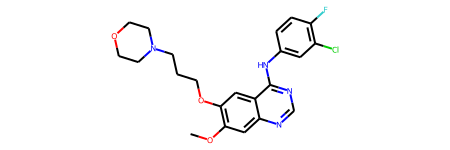

In [5]:
query = 'COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4'  # Gefitinib
print("The structure of Gefitinib:")
Chem.MolFromSmiles(query)

### Query PubChem for similar compounds

Use the a `SMILES` string to query similar compounds in PubChem.

> Tip: You can check [Talktorial T001](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/1_ChEMBL/T1_ChEMBL.ipynb) to see how to do a similar operation with ChEMBL database.

In the following function, we will query PubChem service for the similar compounds to the given one. It's done by four main steps:

1. Input the canonical smile string for the given compound to create a new task, so we obtain a job key here. Note that this asynchronous API will not return the data immediately. In this case, the callback will be provided only when the requested resource is ready, which checked by the job key. So asynchronous requests are useful to work around certian slower operations. 
2. Check if the job finished in time limit. The standard time limit in PubChem is 30 seconds (we can reset it). It means that if a request is not completed within time limit, a timeout error will be returned. So, be nice and wait for the callback.
3. Download results (PubChem IDs in this case) when finished.
4. Get the canonical smiles from teh PubChem IDs.

In [6]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=10):
    """
    Query PubChem for similar compounds

    Parameters
    ----------
    simles : str
    threshold : int
        The threshold of similarity, default 75%.
    n_records : int
        The number of feedback records.

    Returns
    -------
    list 
    """
    # Step 1: Creat the task to obtain a job key
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    # Step 2: Check if the job finished. Response is async, poll every second for 25 seconds to see if it's done
    # Step 3: Download results (PubChem IDs) when finished)
    attempts = 25
    while attempts:
        r = requests.get(
            f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
        )
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    #  Step 4: Get SMILES from the PubChem IDs
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [7]:
similar_smiles = query_pubchem_for_similar_compounds(query)

Then we create the RDKit molecules and depict them.

,smiles,ROMol
0,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...,
1,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,

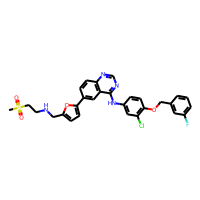
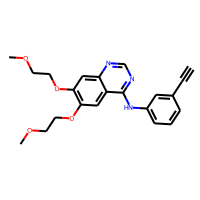

In [8]:
query_results_df = pd.DataFrame({"smiles": similar_smiles})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(2)

### Show the results
Show the compounds with images using the RDKit draw tool.

In [9]:
def multi_preview_smiles(query, *smiles):
    """
    Show the compounds with images.

    Parameters
    ----------
    *simles : list

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"{s[:30]}..." for s in smiles]  # shorten the smiles string to avoid text overlap
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    query = Chem.MolFromSmiles(query)
    return MolsToGridImage(
        [query]+molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=(["Gefitinib"]+legends),
        useSVG=True,
    )

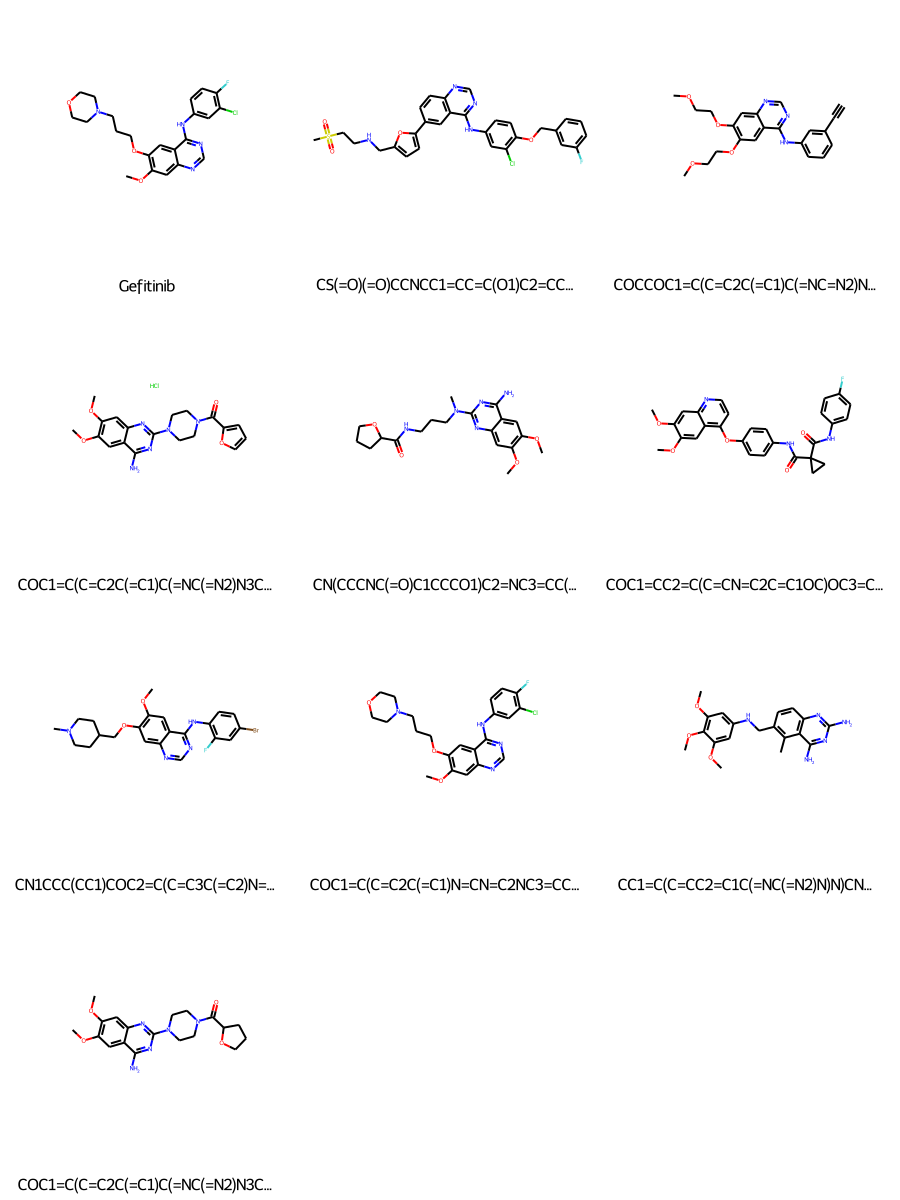

In [10]:
multi_preview_smiles(query, *similar_smiles)

## Discussion

In this notebook you have learned how to access and search similar compounds from PubChem database via PUG-REST programmatic access. Is it convenient? PUG-REST can do more than that. See [PUG-REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial) to get more power! 


## Quiz

- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](http://www.icoa.fr/pkidb/) and check against the list of smiles)